In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geopandas as gpd
from shapely.geometry import Point

from scipy.interpolate import griddata

In [2]:
### Import file 1
# gsas_filepath =
gsas_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GSAS_GM_094C_Quadrangle_Geochemical_Data.xlsx"

gsas_raw_data = pd.read_excel(gsas_filepath, sheet_name="DS_RGP_GSAS_GM_094C")
print('File imported successfully')
gsas_raw_data.head(5)

File imported successfully


,Project Code,GSAS,Project Name,Geochemical Survey Arabian Shield,Unnamed: 4,Analyte,Br,Cl,Cr,Hf,...,Sb,Se,Ag,B,Sn,F,N,S,TC,LOI
0,Geologic Quad number,GM-94,Geologic Quad name,Jabal Al Hasir,NaN,Extraction_Code,NONE,NONE,NONE,NONE,...,AR,MAC,NONE,NONE,NONE,CFU,NONE,NONE,NONE,NONE
1,Sample Preparation Manual,Version 1.1,Chemical Analysis Manual,Version 1.1,NaN,Instrument_Code,XRFS-WD,XRFS-WD,XRFS-WD,XRFS-WD,...,AFS,AFS,ES,ES,ES,ISE,GC,IRS,IRS,GR
2,Organised by,Saudi Geological Survey,Conducted by,China Geological Survey,NaN,Unit,mg/kg,mg/kg,mg/kg,mg/kg,...,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,mg/kg,%,%
3,Sample Field Number,Smaple Code,Lab Sample Number,Longitude,Latitude,DL,0.45,6,2,0.15,...,0.05,0.01,0.012,1,0.2,38.2,10,10,0.01,NaN
4,421911AD001,GSAS / GM-94 / 421911AD001,HT231230001,42.772083,19.99388,NaN,1.4195,62.743,47.29,3.49742,...,0.422,0.2038,0.036737,16.64191,1.402524,487.1,89.39,124.6,0.6725,3.81


In [33]:
### Set custom headers, drop header rows, and reset index
gsas_columns_part1 = gsas_raw_data.iloc[3, 0:5].tolist()


gsas_data = gsas_raw_data.copy()

gsas_columns = (
    gsas_columns_part1 + gsas_data.columns[len(gsas_columns_part1) :].tolist()
)
print("length of columns:", len(gsas_columns))

# Assign the new column names to the DataFrame
gsas_data.columns = gsas_columns
gsas_data.columns = gsas_data.columns.str.strip()  # Strip any whitespace
print("length of data columns:", len(gsas_data.columns))

# Drop header rows and reset index, drop analyte column
gsas_data = gsas_data.iloc[4:].reset_index(drop=True)
gsas_data = gsas_data.drop(gsas_data.columns[5], axis=1)

print("Number of columns in part1:", len(gsas_columns_part1))
print('columns1 =', gsas_columns_part1)

print("Total columns in data:", gsas_data.shape[1])

gsas_data['Au']

length of columns: 63
length of data columns: 63
Number of columns in part1: 5
columns1 = ['Sample Field Number', 'Smaple Code', 'Lab Sample Number', 'Longitude', 'Latitude']
Total columns in data: 62


0       0.929
1       0.754
2        0.84
3       5.736
4       7.874
        ...  
2723    0.213
2724    0.166
2725    0.231
2726    0.227
2727    0.491
Name: Au, Length: 2728, dtype: object

In [8]:
def calculate_below_detection_percentage(
    df: pd.DataFrame, dl_row1: pd.Series, dl_row2: pd.Series
) -> dict:
    """
    Calculates the percentage of values below the detection limit (DL) for each column in the DataFrame.

    Parameters:
    - df: Input DataFrame containing numerical data with possible values below DL.
    - dl_row1: First row containing DL components.
    - dl_row2: Second row containing DL components.

    Returns:
    - A dictionary with column names as keys and the percentage below DL as values.
    """
    # Compute the DL values
    detection_limits = pd.to_numeric(dl_row1, errors="coerce").fillna(
        0
    ) + pd.to_numeric(dl_row2, errors="coerce").fillna(0)

    # Initialize a dictionary to store results
    below_dl_percentage = {}

    # Iterate over columns starting from index 3 (assuming first 3 are non-numeric metadata)
    for col_index in range(3, df.shape[1]):
        col_name = df.columns[col_index]
        dl_value = detection_limits[col_index]

        # Count the number of values below the DL
        below_dl_count = (df.iloc[:, col_index] < dl_value).sum()

        # Calculate the percentage below DL
        below_dl_percentage[col_name] = (below_dl_count / len(df)) * 100

    return below_dl_percentage


def plot_histograms(df, elements, bins=20, lower_cutoff=None, upper_cutoff=None):
    """
    Plots histograms for selected elements with optional cutoff for outliers.

    Parameters:
    - df: DataFrame containing geochemical data.
    - elements: List of column names corresponding to the elements.
    - bins: Number of bins for the histograms.
    - lower_cutoff: Lower cutoff as a decimal percentage (e.g., 0.01 for 1st percentile).
    - upper_cutoff: Upper cutoff as a decimal percentage (e.g., 0.99 for 99th percentile).
    """
    num_elements = len(elements)
    cols = 3  # Number of columns in the subplot grid
    rows = math.ceil(num_elements / cols)  # Calculate required rows dynamically

    plt.figure(figsize=(cols * 4, rows * 3))  # Adjust figure size based on grid

    for i, element in enumerate(elements, start=1):
        plt.subplot(rows, cols, i)  # Adjust grid dynamically
        if element in df.columns:
            data = df[element].dropna()  # Remove NaN values

            # Apply lower and/or upper cutoffs if defined
            if lower_cutoff is not None:
                lower_bound = np.percentile(data, lower_cutoff * 100)
                data = data[data >= lower_bound]
            if upper_cutoff is not None:
                upper_bound = np.percentile(data, upper_cutoff * 100)
                data = data[data <= upper_bound]

            plt.hist(data, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)
            plt.title(f"Distribution of {element}", fontsize=12)
            plt.xlabel(f"{element} Concentration (ppm)", fontsize=10)
            plt.ylabel("Frequency", fontsize=10)
            plt.xticks(rotation=45)  # Rotate x-axis tick labels for readability
        else:
            plt.title(f"{element} not found in dataset", fontsize=12)
            plt.axis("off")  # Hide axes for missing data

    plt.tight_layout()  # Adjust spacing
    plt.show()  

In [34]:
### Clean data

# Identify column labels
gsas_labels = gsas_raw_data.iloc[2].astype(str).fillna("")  # Row with the units
gsas_labels = gsas_labels.str.strip()  # Remove leading/trailing whitespace
gsas_labels = gsas_labels.drop(gsas_labels.index[5])

# Iterate through all column labels and apply appropriate conversions
for col_index, unit in enumerate(gsas_labels):
    if unit == "%":
        # Convert % to ppm (multiply by 10000)
        gsas_data.iloc[:, col_index] = (
            gsas_data.iloc[:, col_index].astype(float) * 10000
        )
        print(f"Converted column {gsas_data.columns[col_index]} from % to ppm.")
    elif unit == "ng/g":
        # Convert ng/g to ppm 
        gsas_data.iloc[:, col_index] = gsas_data.iloc[:, col_index].astype(float) / 1000
        print(f"Converted column {gsas_data.columns[col_index]} from ng/g to ppm.")
    elif unit == "mg/kg":
        # mg/kg is equivalent to ppm, no conversion needed
        print(
            f"Column {gsas_data.columns[col_index]} is already in ppm (mg/kg). No conversion applied."
        )
    else:
        # Handle columns with no recognized unit or no conversion needed
        print(
            f"Column {gsas_data.columns[col_index]} has unrecognized or no unit. Skipped conversion."
        )

# Print a summary of the updated columns
print("Unit conversion completed.")

Column Sample Field Number has unrecognized or no unit. Skipped conversion.
Column Smaple Code has unrecognized or no unit. Skipped conversion.
Column Lab Sample Number has unrecognized or no unit. Skipped conversion.
Column Longitude has unrecognized or no unit. Skipped conversion.
Column Latitude has unrecognized or no unit. Skipped conversion.
Column Br is already in ppm (mg/kg). No conversion applied.
Column Cl is already in ppm (mg/kg). No conversion applied.
Column Cr is already in ppm (mg/kg). No conversion applied.
Column Hf is already in ppm (mg/kg). No conversion applied.
Column P is already in ppm (mg/kg). No conversion applied.
Column Rb is already in ppm (mg/kg). No conversion applied.
Column Ti is already in ppm (mg/kg). No conversion applied.
Column Zr is already in ppm (mg/kg). No conversion applied.
Converted column SiO2 from % to ppm.
Converted column Al2O3 from % to ppm.
Converted column TFe2O3 from % to ppm.
Converted column K2O from % to ppm.
Column Ba is already i

In [ ]:
### Calculate + plot below detection limit percentage

# Assuming `gsas_raw_data` and `gsas_data` are loaded as in your code
dl_row1 = gsas_raw_data.iloc[5]
dl_row2 = gsas_raw_data.iloc[6]
below_dl_results = calculate_below_detection_percentage(gsas_data, dl_row1, dl_row2)

# Print results
for column, percentage in below_dl_results.items():
    print(f"{column}: {percentage:.2f}% below DL")\
    

# Convert the results to two lists for plotting
columns = list(below_dl_results.keys())
percentages = list(below_dl_results.values())

# Plot the bar chart
plt.figure(figsize=(10, 4))
plt.bar(columns, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Element (Columns)", fontsize=12)
plt.ylabel("Percentage Below Detection Limit (%)", fontsize=12)
plt.title("Percentage of Values Below Detection Limit per Column", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate column names for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()

In [ ]:
### Drop columns with n percentage below detection limit

# Calculate percentage below detection limit
below_dl_results = calculate_below_detection_percentage(
    gsas_data, gsas_raw_data.iloc[5], gsas_raw_data.iloc[6]
)

# Drop columns exceeding the threshold percentage below DL

threshold_below_dl = 90

columns_to_drop = [
    col
    for col, percentage in below_dl_results.items()
    if percentage > threshold_below_dl
]
gsas_data = gsas_data.drop(columns=columns_to_drop)

# Print the columns that were dropped
print(f"Columns dropped due to exceeding {threshold_below_dl}% below DL:")
print(columns_to_drop)

# Ensure no columns with constant values remain
gsas_data = gsas_data.loc[:, gsas_data.nunique() > 1]

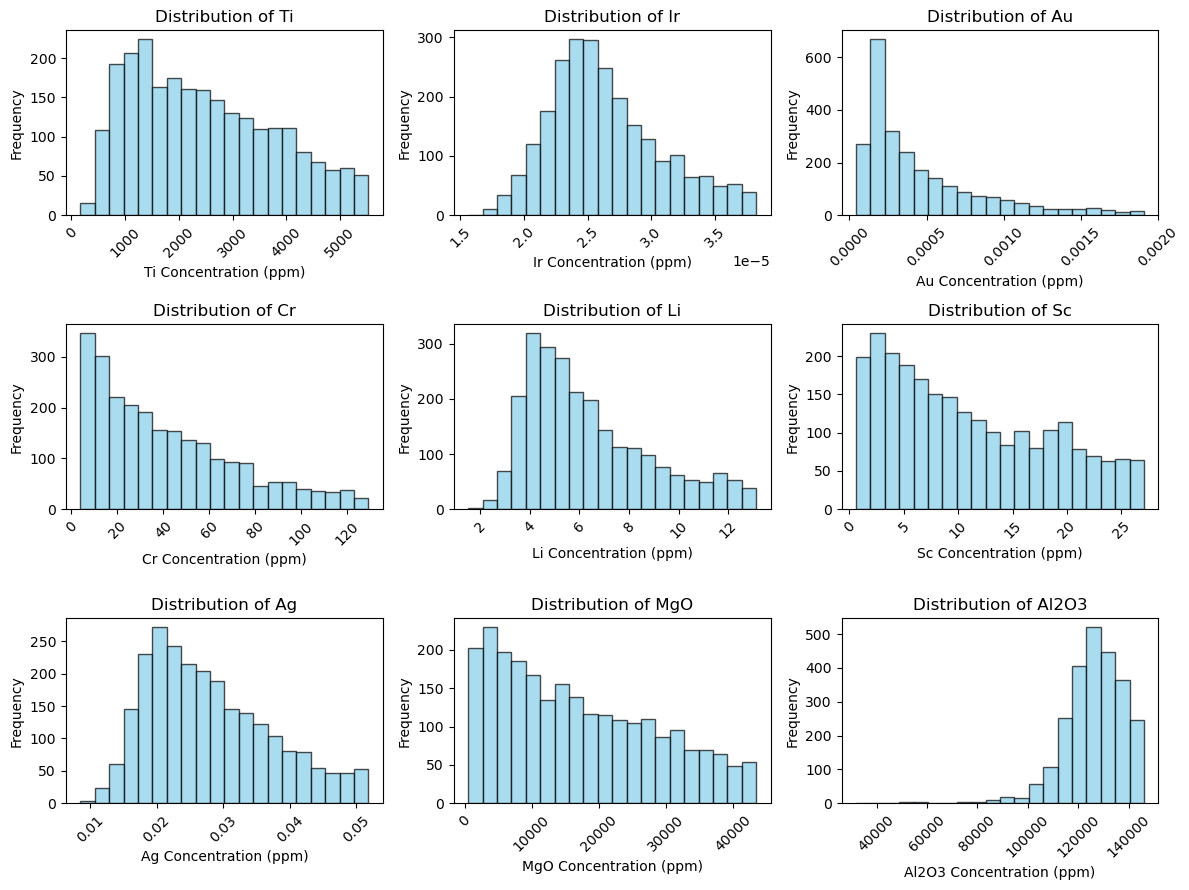

In [ ]:
### Histograms

# Define the precious and base metals to plot
precious_base_metals = ["Cu", "Zn", "Au", "Cr", "Li", 'Sc', 'Ag', 'MgO', 'Al2O3']

# LOOK AT Sr, maybe Ti?

# Call the function with your data
plot_histograms(gsas_data, precious_base_metals, bins=20, lower_cutoff=0, upper_cutoff=0.9)

Statistics:

Average correlation: 0.13696008917760794
Max correlation: 1.0
Min correlation: -0.9133471232933982


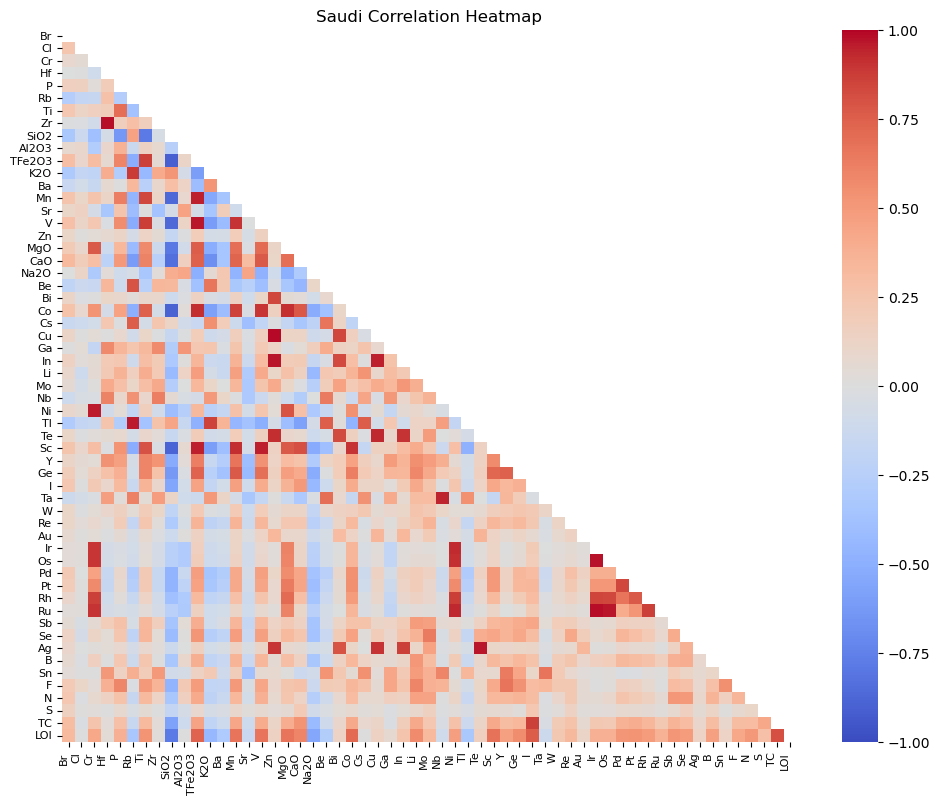

In [48]:
# Corr plot
gsas_corr = gsas_data.iloc[:, 5:].corr()

print("Statistics:\n")
print("Average correlation:", gsas_corr.stack().mean())
print("Max correlation:", gsas_corr.stack().max())
print("Min correlation:", gsas_corr.stack().min())

# Create a mask for the upper triangle
gsas_mask = np.triu(np.ones_like(gsas_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    gsas_corr,
    mask=gsas_mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

# Explicitly set tick positions and labels
tick_positions = np.arange(0.5, len(gsas_corr))
plt.xticks(
    ticks=tick_positions,
    labels=gsas_corr.columns,
    rotation=90,
    fontsize=8,
    ha="right",
)
plt.yticks(
    ticks=tick_positions,
    labels=gsas_corr.index,
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.title("Saudi Correlation Heatmap")
plt.show()

In [49]:
### PCA

# Omit non-numeric columns
gsas_data_pca = gsas_data.copy()
gsas_data_pca = gsas_data_pca.iloc[:, 3:]

scaler = StandardScaler()
gsas_data_scaled = scaler.fit_transform(gsas_data_pca)

# Perform PCA
pca = PCA()
gsas_pca_results = pca.fit_transform(gsas_data_scaled)

# Explained variance
gsas_explained_variance = pca.explained_variance_ratio_
#print("Explained Variance Ratios:", gsas_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    gsas_pca_results, columns=[f"PC{i+1}" for i in range(len(gsas_explained_variance))]
)

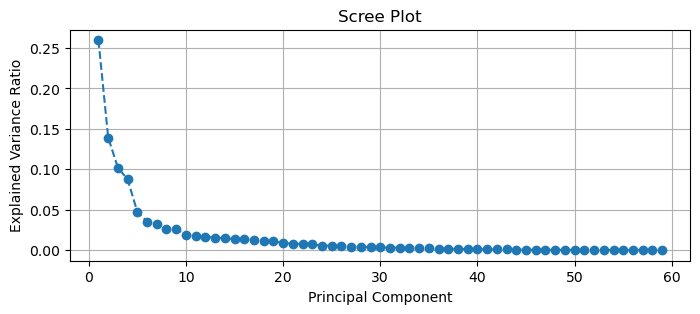

In [50]:
#Plot PCA scree plot
plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(gsas_explained_variance) + 1),
    gsas_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

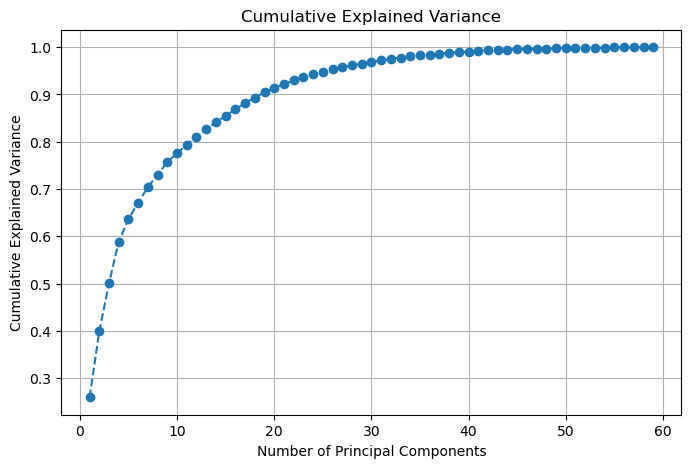

In [51]:
cumulative_variance = gsas_explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

PC1: ['TFe2O3', 'Co', 'SiO2', 'Sc', 'Mn']
PC2: ['Nb', 'Ta', 'Sn', 'Zr', 'Hf']
PC3: ['Ru', 'Ir', 'Os', 'Cr', 'Ni']
PC4: ['Cu', 'Te', 'Zn', 'Ag', 'Bi']
PC5: ['Na2O', 'TC', 'Ga', 'I', 'Sb']


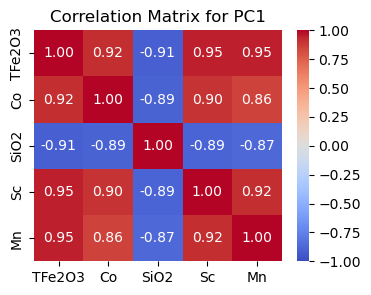

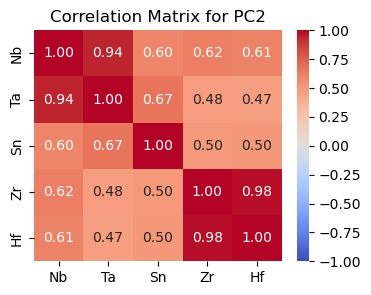

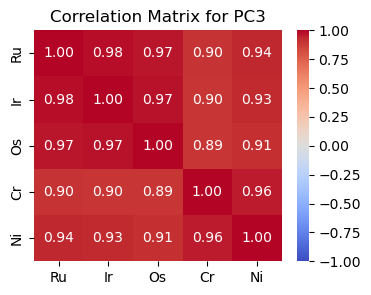

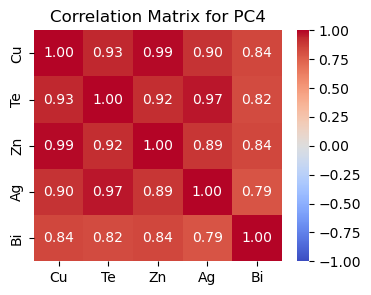

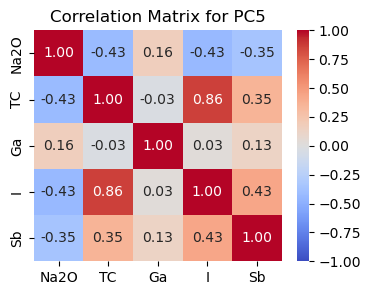

In [52]:
### Extract top features per PC

# Set parameters
num_pcs = 5  # Number of PCs to analyze
top_features_per_pc = 5  # Number of top features to extract per PC

# Prepare lists for groups of features
groups = {}

# Iterate through each PC and extract top features
for pc_index in range(num_pcs):
    # Extract feature contributions for the current PC
    contributions = pd.DataFrame(
        {
            "Feature": gsas_data_pca.columns,
            f"PC{pc_index + 1} Contribution": np.abs(pca.components_[pc_index]),
        }
    )
    # Sort by contribution and select top features
    top_features = contributions.nlargest(
        top_features_per_pc, f"PC{pc_index + 1} Contribution"
    )["Feature"].tolist()
    groups[f"PC{pc_index + 1}"] = top_features

# Display groups of correlated features
for pc, features in groups.items():
    print(f"{pc}: {features}")

# Plot correlation matrices for each PC group
for pc, features in groups.items():
    plt.figure(figsize=(4, 3))
    corr_matrix = gsas_data_pca[features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for {pc}")
    plt.show()

## Findings from PCA corr plots

- PC1:
    - Fe2O3 typically felsic...
    - Co, Sc, Mn all mafic, correlated
    - SiO2 felsic, anti-correlated
    - FELSIC/MAFIC INDEX???

- PC2:
    - Zr/Nb/Hf/Ta all HFSEs, enriched in granitic fractionation
    - Indicitave of pegmatites?
    - PEGMATITE INDEX???
- PC3:
    - Os/Ir/Ru all PGEs, found in orthomagmatic deposits
    - Ni also found in orthomag deposits
    - Cr found in mafic/ultramafic deposits
    - MAFIC INTRUSION INDEX???

- PC4:
    - Bi/Ag/Zn/Cu all major polymetallic deposit indicators
    - Te also found in polymetallic deposits
    - Association with hydrothermal systems?
    - POLYMETALLIC INDICATOR???

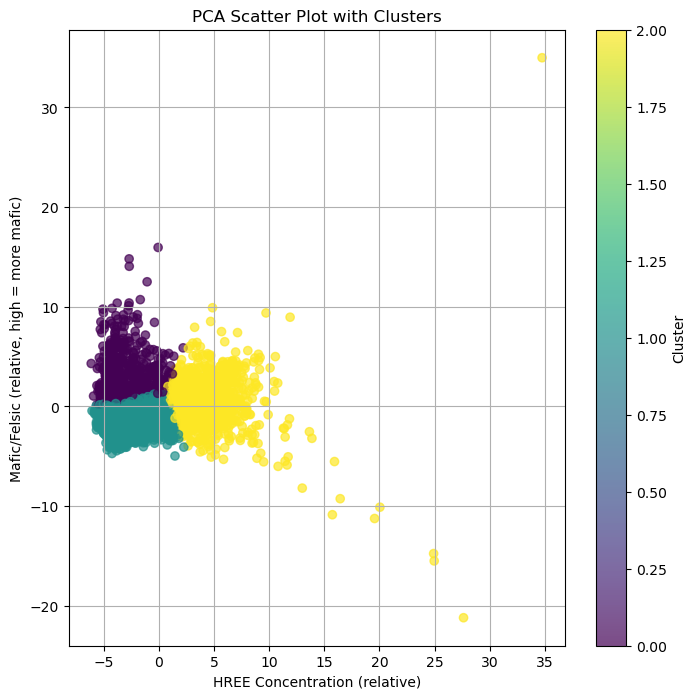

In [53]:
# Perform clustering on the PCA results (e.g., using the first 2 PCs)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df[["PC1", "PC2"]])

# Add cluster labels to the PCA DataFrame
pca_df["Cluster"] = clusters

# Visualize clusters on the PCA scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"], cmap="viridis", alpha=0.7
)
plt.title("PCA Scatter Plot with Clusters")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

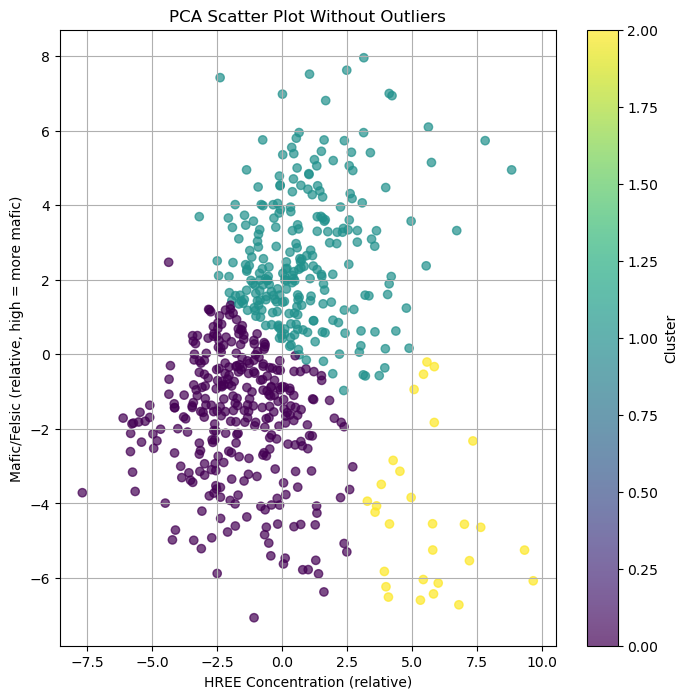

In [17]:
# Define thresholds for PC1 (HREE concentration) and PC2 (mafic/felsic)
pc1_threshold = 10  # Keep samples with PC1 < 10
pc2_threshold = 8  # Keep samples with PC2 < 8

# Filter out outliers
filtered_data = pca_df[
    (pca_df["PC1"] < pc1_threshold) & (pca_df["PC2"] < pc2_threshold)
]

# Replot without outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    filtered_data["PC1"],
    filtered_data["PC2"],
    c=filtered_data["Cluster"],
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(label="Cluster")
plt.title("PCA Scatter Plot Without Outliers")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.grid()
plt.show()

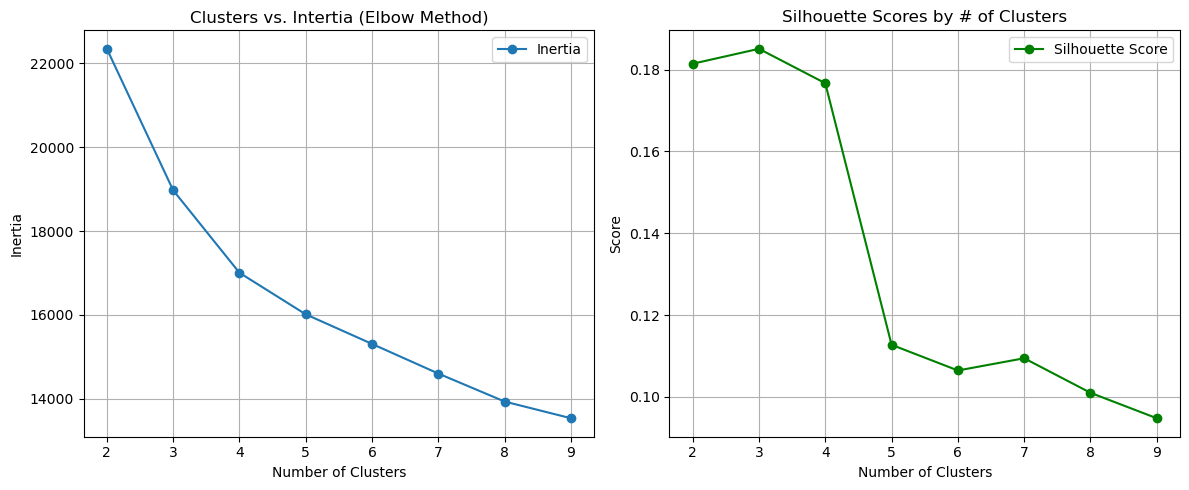

In [19]:
# Step 1: Preprocessing - Select numeric geochemical data and standardize
gsas_data_numeric = gsas_data.iloc[:, 3:].copy()  # Exclude non-numeric columns
gsas_data_numeric = gsas_data_numeric.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric
scaler = StandardScaler()
gsas_data_scaled2 = scaler.fit_transform(gsas_data_numeric)

# Step 2: Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette = []

for k in range(2, 10):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gsas_data_scaled2)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(gsas_data_scaled2, kmeans.labels_))

# Plot Inertia (Elbow) and Silhouette Scores
plt.figure(figsize=(12, 5))

# Inertia (Elbow)
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker="o", label="Inertia")
plt.title("Clusters vs. Intertia (Elbow Method)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette, marker="o", label="Silhouette Score", color="green")
plt.title("Silhouette Scores by # of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Step 3: Perform K-means clustering with optimal number of clusters (e.g., k=3)
gsas_optimal_k = 3  # Based on the elbow plot
gsas_kmeans = KMeans(n_clusters=gsas_optimal_k, random_state=42)
gsas_clusters = gsas_kmeans.fit_predict(gsas_data_scaled2)

# Step 4: Convert scaled data back to a DataFrame
gsas_data_scaled_df = pd.DataFrame(
    gsas_data_scaled2, columns=gsas_data_numeric.columns
)  # Use original column names
gsas_data_scaled_df["Cluster"] = gsas_clusters  # Add cluster assignments

# Step 5: Analyze clustering results
print('Clustering Complete\n.............\n')
print(
    gsas_data_scaled_df.groupby("Cluster").mean()
)  # Compare mean geochemical values for each cluster

Clustering Complete
.............

             SiO2     Al2O3     Fe2O3      TiO2       CaO       MgO      Na2O  \
Cluster                                                                         
0        0.635826  0.084096 -0.547981 -0.377035 -0.468045 -0.518321  0.417597   
1       -0.830579 -0.022128  0.646364  0.441713  0.716625  0.739065 -0.550555   
2        0.544685 -0.672216  0.119881  0.108050 -1.293610 -0.969875  0.400572   

              K2O       MnO      P2O5  ...        Sm        Sr        Ta  \
Cluster                                ...                                 
0        0.256426 -0.606546 -0.309360  ... -0.182200  0.227021  0.023468   
1       -0.512573  0.681734  0.433997  ... -0.113028 -0.159971 -0.054810   
2        1.726438  0.418679 -0.518511  ...  2.822057 -0.964301  0.225018   

               Tb        Th         V         Y        Yb        Zn        Zr  
Cluster                                                                        
0       -0.205470 

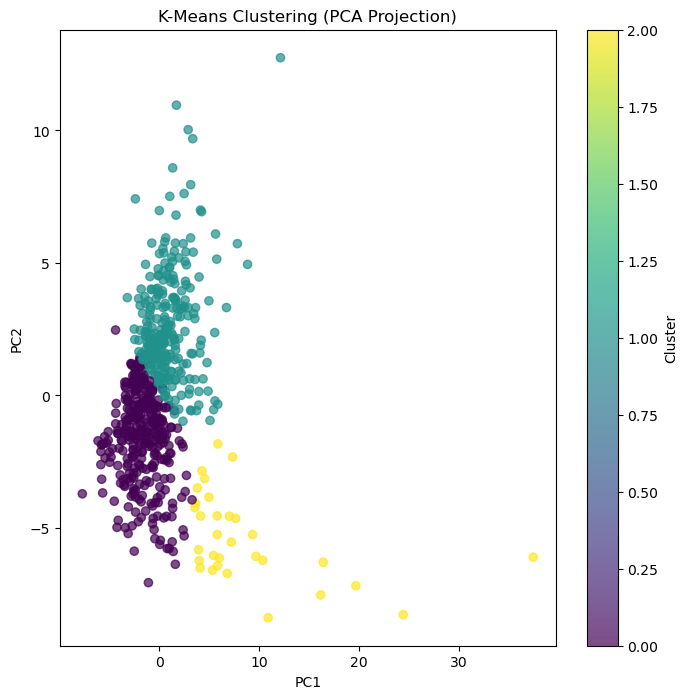

In [21]:
# Reduce dimensions with PCA for visualization
pca2 = PCA(n_components=3)
gsas_data_pca2 = pca2.fit_transform(gsas_data_scaled2)

# Plot clusters
PC1 = 0
PC2 = 1

plt.figure(figsize=(8, 8))
plt.scatter(gsas_data_pca2[:, PC1], gsas_data_pca2[:, PC2], c=gsas_clusters, cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel(f"PC{PC1+1}")
plt.ylabel(f"PC{PC2+1}")
plt.colorbar(label="Cluster")
plt.show()

In [22]:
### Spatial Investigation

gsas_data_spatial = gsas_data.iloc[:, 1:].copy()  
gsas_data_spatial = gsas_data_spatial.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric

# Convert the DataFrame to a GeoDataFrame
gsas_data_spatial["geometry"] = gsas_data_spatial.apply(
    lambda row: Point(row["LONG"], row["LAT"]), axis=1
)
gsas_geo_data = gpd.GeoDataFrame(
    gsas_data_spatial, geometry="geometry", crs="EPSG:4326"
)  # WGS84 CRS
gsas_geo_data["Cluster"] = gsas_clusters

# Inspect the GeoDataFrame
#print(gsas_geo_data.head())
#print(gsas_geo_data["Cluster"].unique())

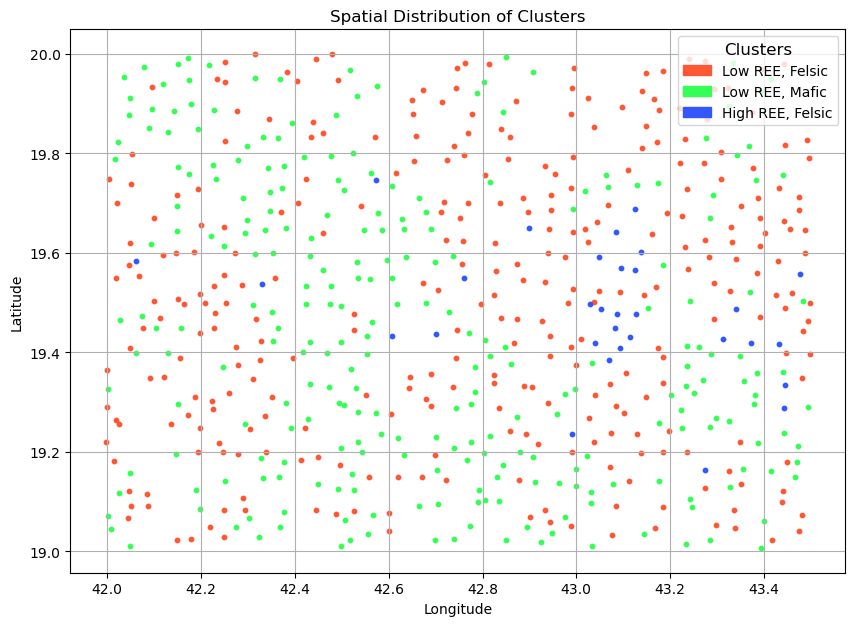

In [23]:
### Spatial Analysis

# Custom cluster colors (ensure consistency with the plot)
cluster_colors = {
    0: "#FF5733",
    1: "#33FF57",
    2: "#3357FF",
}  # Vibrant colors for clusters

# Add a 'Color' column to GeoDataFrame
gsas_geo_data["Color"] = gsas_geo_data["Cluster"].map(cluster_colors)

# Define new names for the clusters
cluster_names = {0: "Low REE, Felsic", 1: "Low REE, Mafic", 2: "High REE, Felsic"}

# Add a new column to the GeoDataFrame with descriptive cluster names
gsas_geo_data["Cluster_Name"] = gsas_geo_data["Cluster"].map(cluster_names)

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))
for cluster, color in cluster_colors.items():
    subset = gsas_geo_data[gsas_geo_data["Cluster"] == cluster]
    subset.plot(color=color, markersize=10, ax=ax, label=f"Cluster {cluster}")

# Add a categorical legend (aligned with cluster colors)
handles = [
    mpatches.Patch(color=color, label=cluster_names[cluster])
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=handles, title="Clusters", loc="upper right", fontsize=10, title_fontsize=12
)

# Add titles and labels
plt.title("Spatial Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

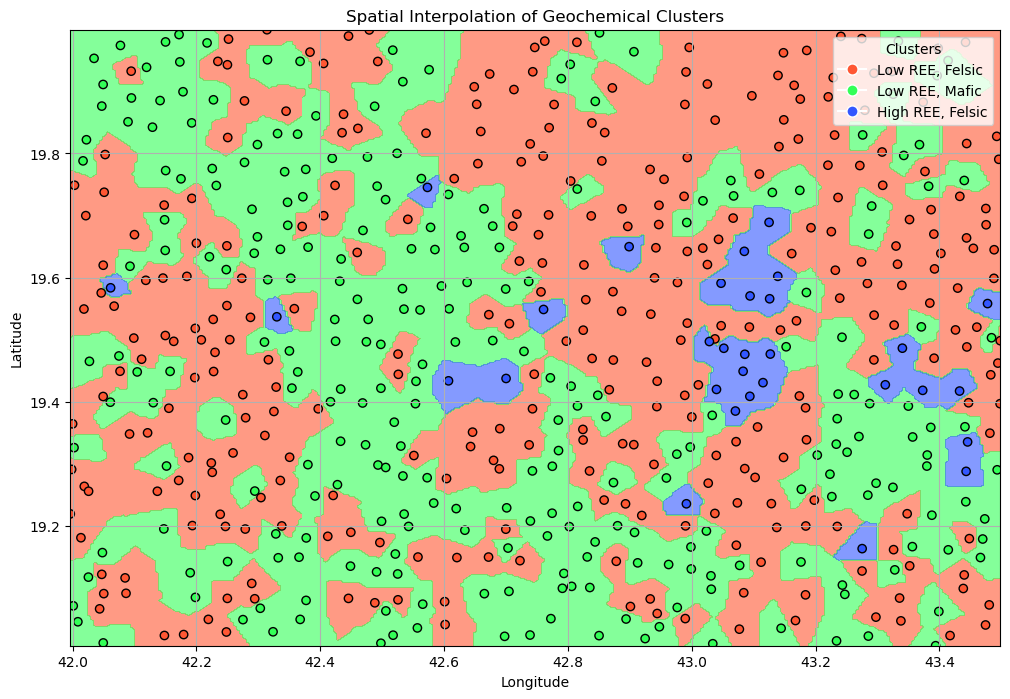

In [24]:
# Extract spatial coordinates and cluster labels
x = gsas_geo_data["LONG"].values
y = gsas_geo_data["LAT"].values
z = gsas_geo_data["Cluster"].values  # Cluster labels

# Define the grid for interpolation
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),  # Adjust resolution
    np.linspace(y.min(), y.max(), 300),
)

# Perform nearest neighbor interpolation
zi = griddata((x, y), z, (xi, yi), method="nearest")

# Use your custom colors for the clusters
custom_cmap = ListedColormap([cluster_colors[i] for i in sorted(cluster_colors.keys())])

# Plot the interpolated clusters
plt.figure(figsize=(12, 8))
plt.contourf(
    xi,
    yi,
    zi,
    levels=np.arange(len(cluster_colors) + 1) - 0.5,
    cmap=custom_cmap,
    alpha=0.6,
)
#plt.colorbar(ticks=range(len(cluster_colors)), label="Cluster")  # Add a colorbar
plt.scatter(
    x, y, c=z, cmap=custom_cmap, edgecolor="k", label="Sample Points"
)  # Overlay sample points
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Interpolation of Geochemical Clusters")
plt.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=cluster_names[cluster],
            markersize=8,
            markerfacecolor=color,
        )
        for cluster, color in cluster_colors.items()
    ],
    title="Clusters",
    loc="upper right",
)
plt.grid()
plt.show()